# Picking a BART station by Top Sales?
W205, Section 01
Annie Cui, Emily Zhou, Shuo Wang

## Overview
Our goal is to increase AGM brand awareness transbay. One of the ways we'll do that is by piloting pick-up points at 3 BART stations. One of the ways to choose these pick-up points is to identify which stations already have a high number of customers. In this notebook, we'll try a different way: identify the zip codes with the most amount of sales, and see if there's merit to looking at BART stations nearest to the highest-sales zip codes.

In [25]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import psycopg2

In [12]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [ ]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

## Find the top 10 zip codes by total sales
This data frame joins the sales table with the customers table and displays the total sales per zip code. To give a sense of the data, I have outputted the top 5 zip codes in a data frame and plotted a bar chart with the top 10 zip codes.

In [45]:
rollback_before_flag = True
rollback_after_flag = True

query = """
select c.zip,
       sum(s.total_amount) as total_amount_purchased
from sales as s join customers as c
      on s.customer_id = c.customer_id
group by c.zip
order by total_amount_purchased desc
"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df[:5]

,zip,total_amount_purchased
0,33134,1341708
1,37206,1151988
2,37212,1140240
3,98119,1113564
4,37210,1008936


## Plot the top 10 zip codes in a bar chart

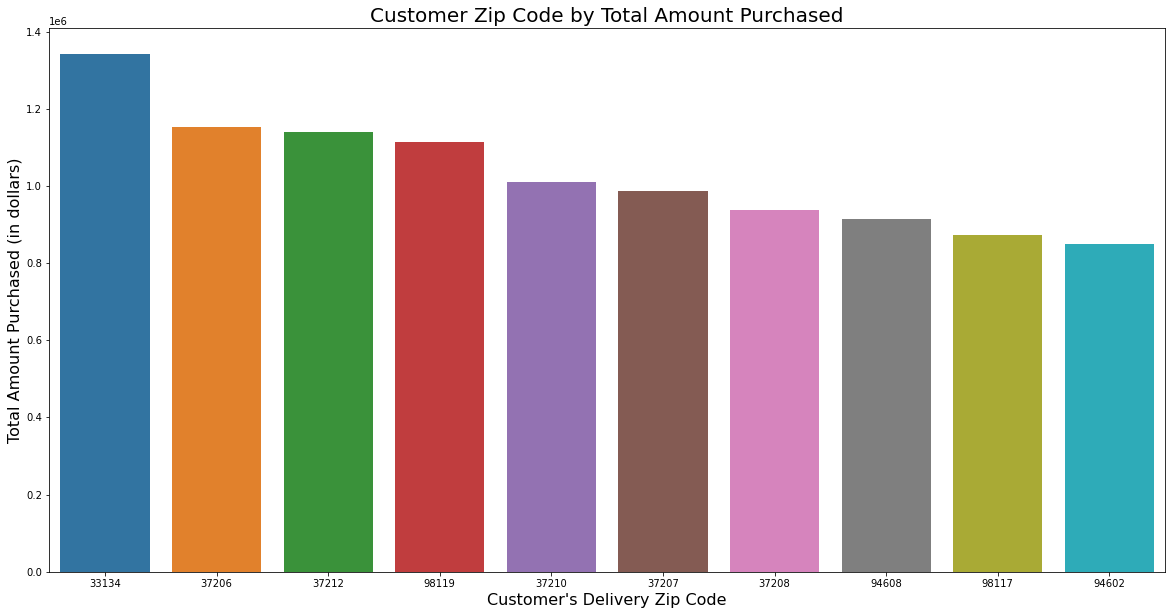

In [46]:
fig = plt.gcf()
fig.set_size_inches(20, 10)

sns.barplot(data=df[:10], x="zip", y="total_amount_purchased")
plt.title('Customer Zip Code by Total Amount Purchased', fontdict={'fontsize': 20})
plt.xlabel('Customer\'s Delivery Zip Code', fontdict={'fontsize': 16})
plt.ylabel('Total Amount Purchased (in dollars)', fontdict={'fontsize': 16})
plt.show()

## Is there a correlation between more customers and more sales?
Now, we'll find the closest BART stations in the zip codes where customers are spending the most. The hope is that customers who are spending more will make the pick-up stations more successful. But we hypothesize that maybe the zip codes with more customers are also the ones with more sales. It might be sufficient to only look at zip codes and total number of customers. This would save compute time, because we would only need to join the customers table with the BART-related tables. 

In [42]:
rollback_before_flag = True
rollback_after_flag = True

query = """
with a as 
(
  select zip,
         count(*) as num_customers
  from customers
  group by zip
  order by num_customers desc
),
b as
(
  select c.zip,
         sum(s.total_amount) as total_amount_purchased
  from sales as s join customers as c
        on s.customer_id = c.customer_id
  group by c.zip
  order by total_amount_purchased desc
)
select a.zip,
       a.num_customers,
       b.total_amount_purchased
from a join b
       on a.zip = b.zip
"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df[:5]

,zip,num_customers,total_amount_purchased
0,33134,419,1341708
1,98117,315,872520
2,98125,296,846804
3,94602,260,848292
4,94530,258,827292


## Scatterplot of Zip Code Data
Below is the scatter plot of customer zip codes. The total sales in dollars against the total customers in the zip code.

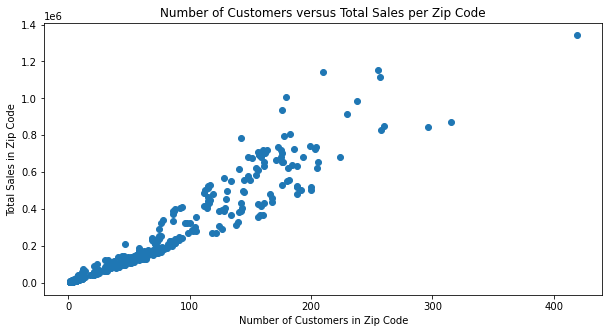

In [43]:
plt.figure(figsize=(10,5))
plt.scatter(df['num_customers'], df['total_amount_purchased'])
plt.title('Number of Customers versus Total Sales per Zip Code')
plt.xlabel('Number of Customers in Zip Code')
plt.ylabel('Total Sales in Zip Code')
plt.show()

We can see above, those two variables are correlated positively. In the past, we see that generally, a zip code with more customers also has more sales. So we'll take the assumption that a zip code with more unique customers will also have more sales. This way, we can avoid needing to also join the sales table to the customers table.